### imports

In [15]:
from SEAM.utils import *
import SEAM
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
from sklearn.decomposition import PCA
import re
from scipy.spatial.distance import *
from skimage import color
from skimage.segmentation import *
import imageio
from scipy import ndimage as ndi
import palettable


### settings

In [16]:
sns.set_style('white')
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 2}

# matplotlib.rc('font', **font)
# matplotlib.rcParams.update({'font.size': 2})

import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title




cmp_use = palettable.cartocolors.qualitative.Bold_10.mpl_colors


### functions

In [3]:

def intersection_over_union(ground_truth, prediction):
    
    # Count objects
    true_objects = len(np.unique(ground_truth))
    pred_objects = len(np.unique(prediction))
    
    # Compute intersection
    h = np.histogram2d(ground_truth.flatten(), prediction.flatten(), bins=(true_objects,pred_objects))
    intersection = h[0]
    
    # Area of objects
    area_true = np.histogram(ground_truth, bins=true_objects)[0]
    area_pred = np.histogram(prediction, bins=pred_objects)[0]
    
    # Calculate union
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    union = area_true + area_pred - intersection
    
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    
    # Compute Intersection over Union
    union[union == 0] = 1e-9
    IOU = intersection/union
    
    return IOU


def measures_at(threshold, IOU):
    
    matches = IOU > threshold
    
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    
    assert np.all(np.less_equal(true_positives, 1))
    assert np.all(np.less_equal(false_positives, 1))
    assert np.all(np.less_equal(false_negatives, 1))
    
    TP, FP, FN = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    
    f1 = 2*TP / (2*TP + FP + FN + 1e-9)
    
    return f1, TP, FP, FN

# Compute Average Precision for all IoU thresholds

def compute_af1_results(ground_truth, prediction, results, image_name,Alg,k,count,Type):

    if not (ground_truth.shape[0]==prediction.shape[0] and ground_truth.shape[1]==prediction.shape[1]):
        axis0_len = min(ground_truth.shape[0],prediction.shape[0])
        axis1_len = min(ground_truth.shape[1],prediction.shape[1])
        ground_truth = ground_truth[0:axis0_len,0:axis1_len]
        prediction = prediction[0:axis0_len,0:axis1_len]
    
    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    if IOU.shape[0] > 0:
        jaccard = np.max(IOU, axis=0).mean()
    else:
        jaccard = 0.0
    
    # Calculate F1 score at all thresholds
    for t in np.arange(0.05, 1, 0.05):
        f1, tp, fp, fn = measures_at(t, IOU)
        AP = tp/(tp+fp+fn)
        res = {"Image": image_name, 'Type':Type,'Alg':Alg,'Parameter':k,"Threshold": t, "F1": f1, "Jaccard": jaccard, "TP": tp, "FP": fp, "FN": fn,'AP':AP,'Count':count}
        
        row = len(results)
        results.loc[row] = res
        
    return results

def filter_mask(sc,threshold=(2,100)):
    segmented_cells = sc.copy()
    unique_idx,unique_count = np.unique(segmented_cells,return_counts=1)
    filtered_idx = unique_idx[np.where((unique_count>threshold[1]) | (unique_count<threshold[0]))]
    
    segmented_cells[np.isin(segmented_cells,filtered_idx)] = 0
    segmented_cells_new = np.zeros_like(segmented_cells)
    segmented_cells_new[segmented_cells!=0]=1
    segmented_cells_new,_ = ndi.label(segmented_cells_new)
    return segmented_cells_new

    

### get segments

In [5]:
with open('/home/yzy/bioSIMS/data/Segment/Segment_Cut/Cut_256.pickle', 'rb') as handle:
    Cut_mask_dict = pickle.load(handle)
with open('/home/yzy/bioSIMS/data/Segment/Segment_SIMS/SIMS_256_rotation.pickle', 'rb') as handle:
    SIMS_dict = pickle.load(handle)
with open('/home/yzy/bioSIMS/data/Segment/Segment_Human_256/Human_256_int.pickle', 'rb') as handle:
    Human_int_dict = pickle.load(handle)
with open('/home/yzy/bioSIMS/data/Segment/Segment_WSedt/WSedt_mask.pickle', 'rb') as handle:
    WSedt_int_dict = pickle.load(handle)

with open('/home/yzy/bioSIMS/data/Segment/Segment_HMRF/HMRF_mask.pickle', 'rb') as handle:
    HMRF_mask_dict = pickle.load(handle)
with open('/home/yzy/bioSIMS/data/Segment/Segment_RW/RW_mask.pickle', 'rb') as handle:
    RW_int_dict = pickle.load(handle)
with open('/home/yzy/bioSIMS/data/Segment/Segment_Threshold/Threshold_mask.pickle', 'rb') as handle:
    Threshold_int_dict = pickle.load(handle)
with open('/home/yzy/bioSIMS/data/Segment/Segment_EB/EB_mask.pickle', 'rb') as handle:
    EB_int_dict = pickle.load(handle)


### transform SIMSCut and HMRF segments from bool into int

In [6]:
Cut_int_dict = {}
for tissue in Cut_mask_dict.keys():
    cur_mask = Cut_mask_dict[tissue]
    cur_int,_ = ndi.label(cur_mask)
    Cut_int_dict[tissue] = cur_int
HMRF_int_dict = {}
for tissue in HMRF_mask_dict.keys():
    HMRF_int_dict[tissue] = {}
    for k in HMRF_mask_dict[tissue].keys():
        
        cur_mask = HMRF_mask_dict[tissue][k]
    
        cur_int,_ = ndi.label(cur_mask)
        HMRF_int_dict[tissue][k] = cur_int
    

### make alg_name:segment_rst dict for use

In [7]:
Alg_dict = {
    'SIMSCut':Cut_int_dict,
    'WSedt':WSedt_int_dict,
    'HMRF':HMRF_int_dict,
    'RW':RW_int_dict,
    'Threshold':Threshold_int_dict,
    'EB':EB_int_dict
}

### create empty result dataframe

In [8]:
results = pd.DataFrame({'Image':[],'Alg':[],'Parameter':[],'Threshold':[],'AP':[],'F1':[],'Jaccard':[],'TP':[],'FP':[],'FN':[]})


### sample name list

In [9]:
tissue_list = [
    'A549','Hela','SK','10A','MCF7',
    'Intestine','Kidney','Lung',
    'Liver_1','Liver_2','Liver_3','Liver_4','Liver_5','Liver_6',
    'R1','R2','R3','R4','R5','R6','R7','R8','R9','R10'
]
type_list = [
    'CellLine','CellLine','CellLine','CellLine','CellLine',
    "MouseTissue","MouseTissue","MouseTissue",
    "MouseTissue","MouseTissue","MouseTissue","MouseTissue","MouseTissue","MouseTissue",
    "HumanTissue","HumanTissue","HumanTissue","HumanTissue","HumanTissue","HumanTissue","HumanTissue","HumanTissue","HumanTissue","HumanTissue",
]

### 0~20

A549 SIMSCut -1
A549 WSedt 2
A549 WSedt 3
A549 WSedt 4
A549 WSedt 5
A549 WSgrad 2
A549 WSgrad 3
A549 WSgrad 4
A549 WSgrad 5
A549 HMRF 2
A549 HMRF 3
A549 HMRF 4
A549 HMRF 5
A549 HMRF 6
A549 HMRF 7
A549 HMRF 8
A549 HMRF 9
A549 HMRF 10
A549 RW 2
A549 RW 3
A549 RW 4
A549 RW 5
A549 Threshold 2
A549 Threshold 3
A549 Threshold 4
A549 Threshold 5
A549 EB -1
Hela SIMSCut -1
Hela WSedt 2
Hela WSedt 3
Hela WSedt 4
Hela WSedt 5
Hela WSgrad 2
Hela WSgrad 3
Hela WSgrad 4
Hela WSgrad 5
Hela HMRF 2
Hela HMRF 3
Hela HMRF 4
Hela HMRF 5
Hela HMRF 6
Hela HMRF 7
Hela HMRF 8
Hela HMRF 9
Hela HMRF 10
Hela RW 2
Hela RW 3
Hela RW 4
Hela RW 5
Hela Threshold 2
Hela Threshold 3
Hela Threshold 4
Hela Threshold 5
Hela EB -1
SK SIMSCut -1
SK WSedt 2
SK WSedt 3
SK WSedt 4
SK WSedt 5
SK WSgrad 2
SK WSgrad 3
SK WSgrad 4
SK WSgrad 5
SK HMRF 2
SK HMRF 3
SK HMRF 4
SK HMRF 5
SK HMRF 6
SK HMRF 7
SK HMRF 8
SK HMRF 9
SK HMRF 10
SK RW 2
SK RW 3
SK RW 4
SK RW 5
SK Threshold 2
SK Threshold 3
SK Threshold 4
SK Threshold 5
SK EB -

/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice.


MCF7 HMRF 3
MCF7 HMRF 4
MCF7 HMRF 5
MCF7 HMRF 6
MCF7 HMRF 7
MCF7 HMRF 8
MCF7 HMRF 9
MCF7 HMRF 10
MCF7 RW 2
MCF7 RW 3
MCF7 RW 4
MCF7 RW 5
MCF7 Threshold 2
MCF7 Threshold 3
MCF7 Threshold 4
MCF7 Threshold 5
MCF7 EB -1
Intestine SIMSCut -1
Intestine WSedt 2
Intestine WSedt 3
Intestine WSedt 4
Intestine WSedt 5
Intestine WSgrad 2
Intestine WSgrad 3
Intestine WSgrad 4
Intestine WSgrad 5
Intestine HMRF 2
Intestine HMRF 3
Intestine HMRF 4
Intestine HMRF 5
Intestine HMRF 6
Intestine HMRF 7
Intestine HMRF 8
Intestine HMRF 9
Intestine HMRF 10
Intestine RW 2
Intestine RW 3
Intestine RW 4
Intestine RW 5
Intestine Threshold 2
Intestine Threshold 3
Intestine Threshold 4
Intestine Threshold 5
Intestine EB -1
Kidney SIMSCut -1
Kidney WSedt 2
Kidney WSedt 3
Kidney WSedt 4
Kidney WSedt 5
Kidney WSgrad 2
Kidney WSgrad 3
Kidney WSgrad 4
Kidney WSgrad 5
Kidney HMRF 2
Kidney HMRF 3
Kidney HMRF 4
Kidney HMRF 5
Kidney HMRF 6
Kidney HMRF 7
Kidney HMRF 8
Kidney HMRF 9
Kidney HMRF 10
Kidney RW 2
Kidney RW 3
Kidn

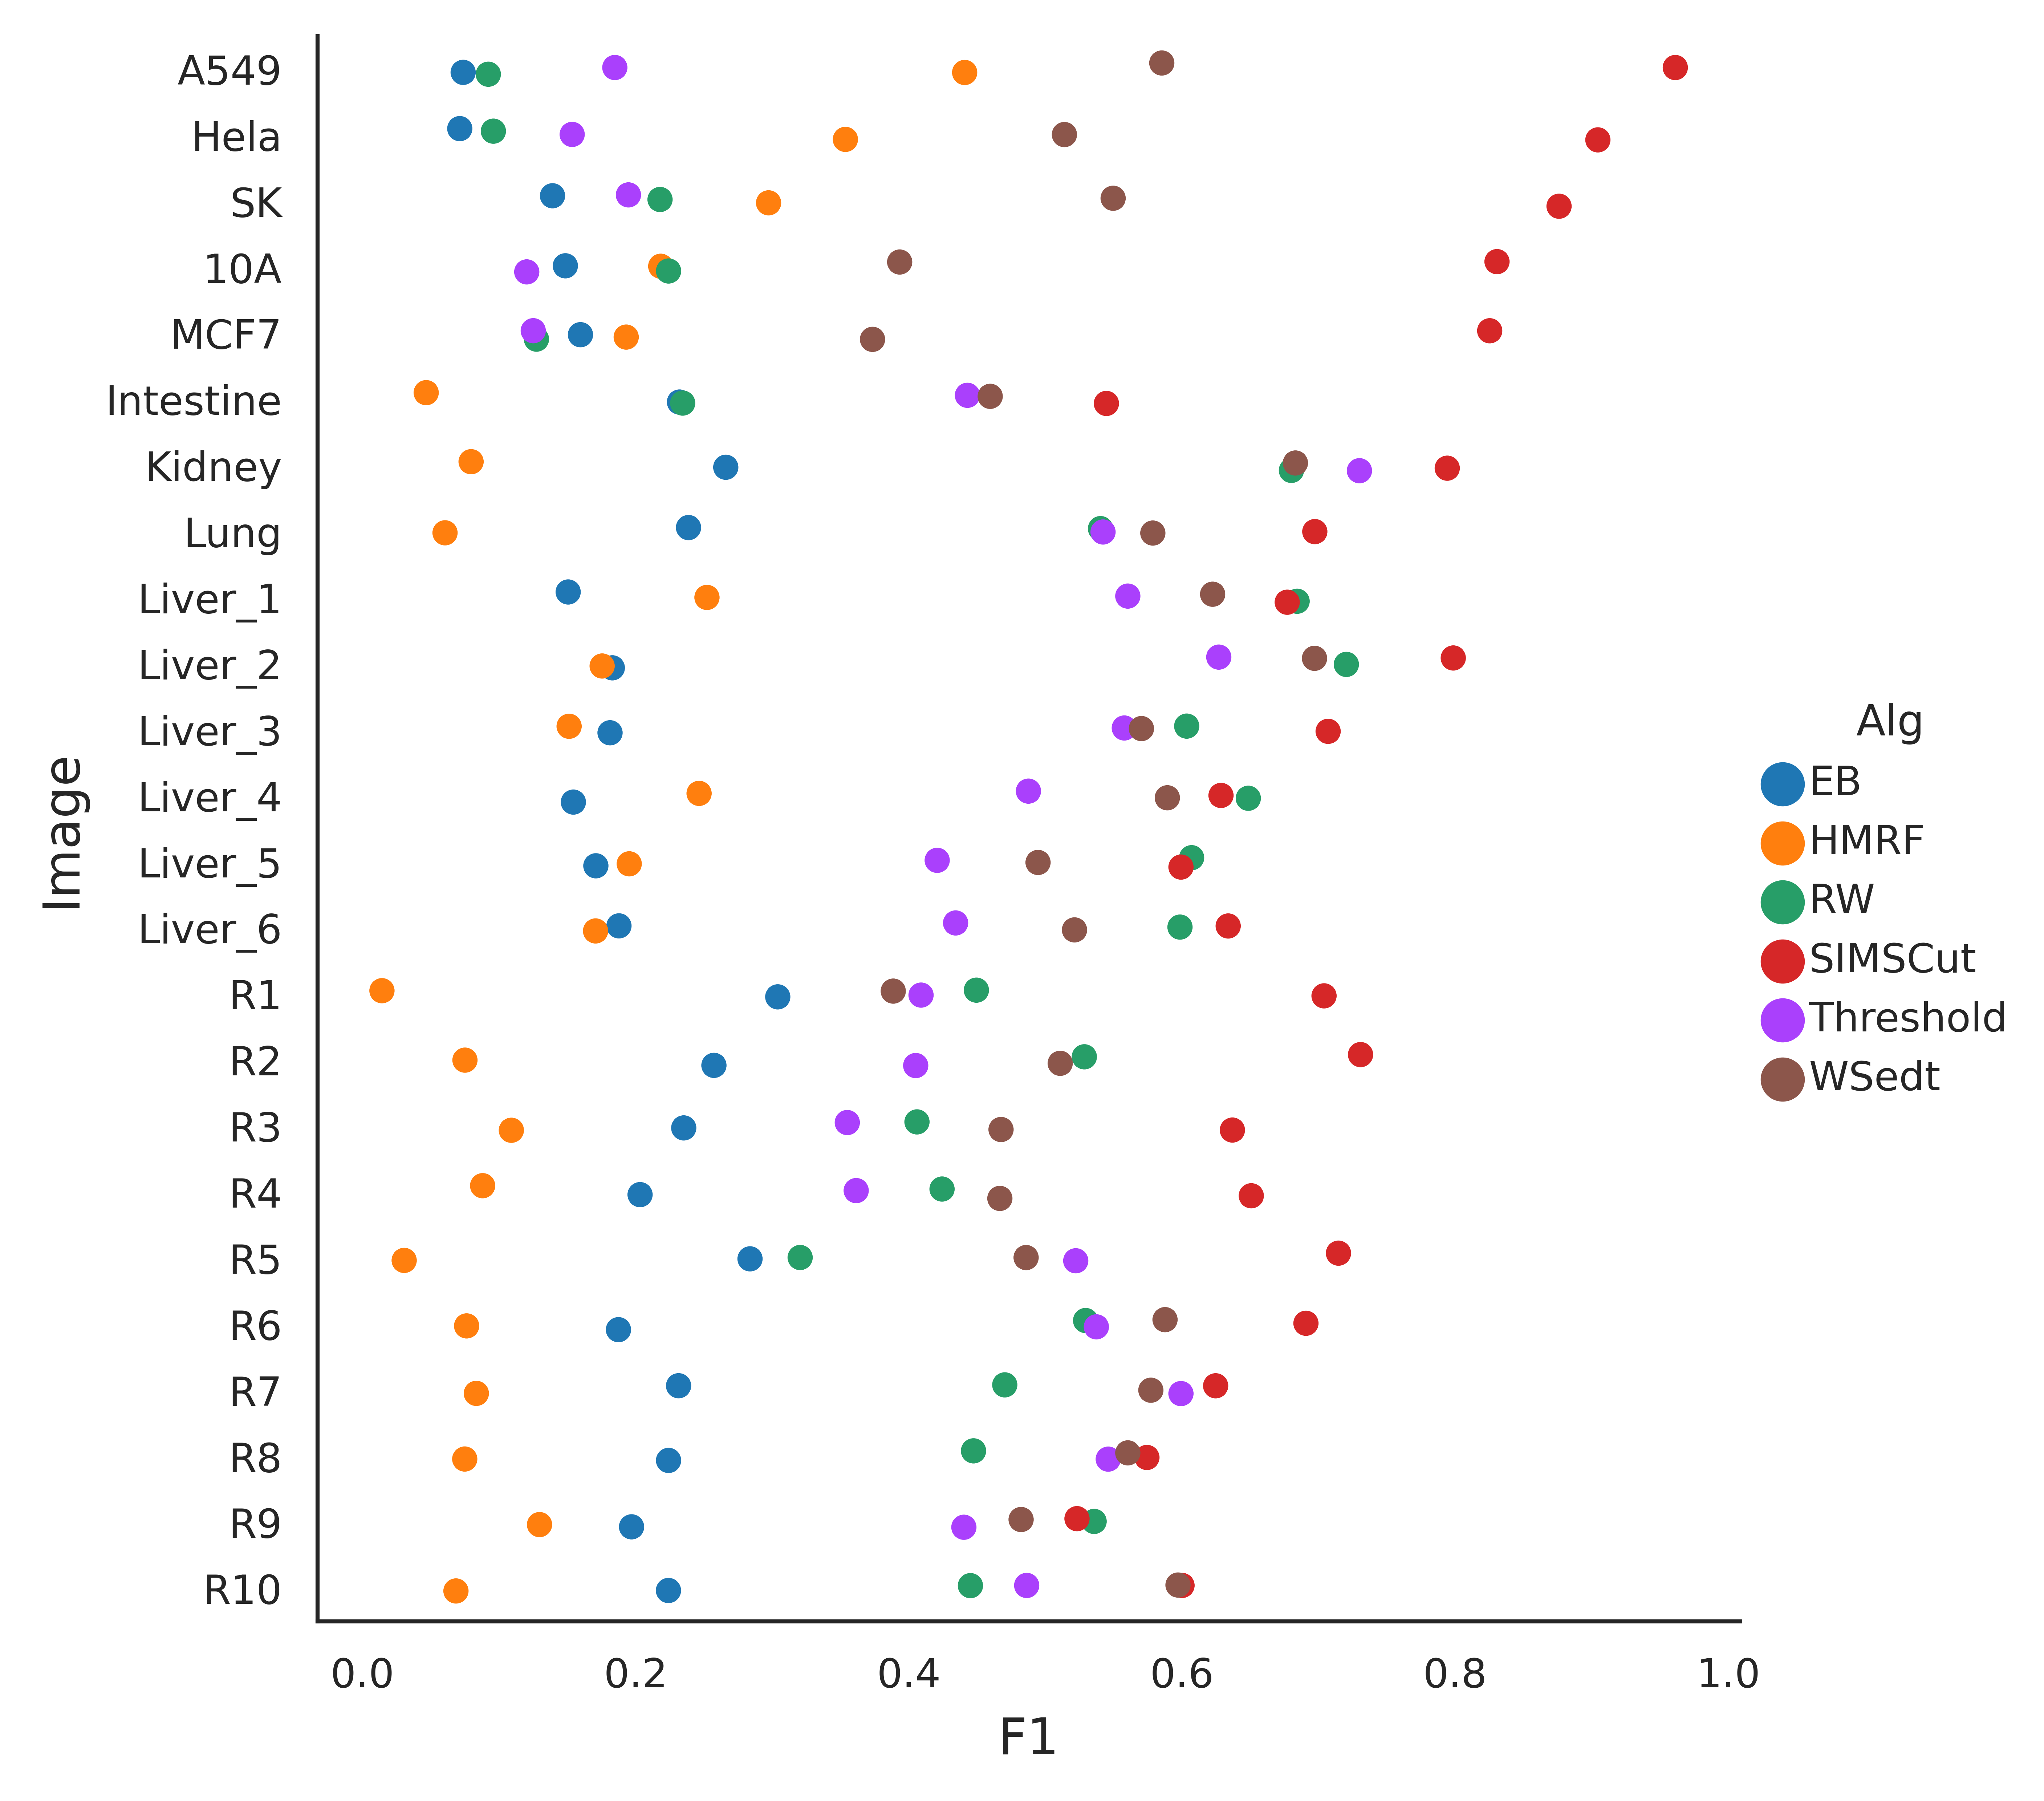

In [489]:
results = pd.DataFrame({'Image':[],'Type':[],'Alg':[],'Parameter':[],'Threshold':[],'AP':[],'F1':[],'Jaccard':[],'TP':[],'FP':[],'FN':[],'Count':[]})

for i in range(len(tissue_list)):
    test_tissue = tissue_list[i]
    cur_human = Human_int_dict[test_tissue]
    cur_type = type_list[i]
    for alg in Alg_dict.keys():
#     for alg in ['SIMSCut']:

        cur_rst_dict = Alg_dict[alg]
        
        cur_tissue_dict = cur_rst_dict[test_tissue]
#             cur_tissue_dict is either a numpy matrix or a dict
        if isinstance(cur_tissue_dict,np.ndarray):
            cur_int = cur_tissue_dict
            if cur_type=='CellLine':
                cur_int = filter_mask(cur_int,threshold=(0,60))
            else:
                cur_int = filter_mask(cur_int,threshold=(0,20))
                
            k=-1
            
            print('{0} {1} {2}'.format(test_tissue,alg,k))
            count = np.unique(cur_int).shape[0]-1
            results = compute_af1_results(cur_human, cur_int, results, test_tissue,alg,k,count,cur_type)
#             results = compute_af1_results( cur_int,cur_human, results, test_tissue,alg,k,count)

        elif isinstance(cur_tissue_dict,dict):
            for k in cur_tissue_dict.keys():
                cur_int = cur_tissue_dict[k]
#                 cur_int = filter_mask(cur_int,threshold=(0,20))
                if cur_type=='CellLine':
                    cur_int = filter_mask(cur_int,threshold=(0,60))
                else:
                    cur_int = filter_mask(cur_int,threshold=(0,20))
              
                print('{0} {1} {2}'.format(test_tissue,alg,k))
                count = np.unique(cur_int).shape[0]-1
                
                results = compute_af1_results(cur_human, cur_int, results, test_tissue,alg,k,count,cur_type)
#                 results = compute_af1_results( cur_int,cur_human, results, test_tissue,alg,k,count)
                
                    
rst_agg = results[results.Threshold>=0.1].groupby(['Image','Alg'], as_index=False).agg({"F1": 'max'})

# filter(0,20) UOI>=0.05
g = sns.catplot(y="Image", x="F1", hue="Alg",order=tissue_list,orient='h',
                 data=rst_agg[rst_agg.Alg!='WSgrad'])
        
        
        
        


A549 SIMSCut -1
A549 WSedt 2
A549 WSedt 3
A549 WSedt 4
A549 WSedt 5
A549 WSgrad 2
A549 WSgrad 3
A549 WSgrad 4
A549 WSgrad 5
A549 HMRF 2
A549 HMRF 3
A549 HMRF 4
A549 HMRF 5
A549 HMRF 6
A549 HMRF 7
A549 HMRF 8
A549 HMRF 9
A549 HMRF 10
A549 RW 2
A549 RW 3
A549 RW 4
A549 RW 5
A549 Threshold 2
A549 Threshold 3
A549 Threshold 4
A549 Threshold 5
A549 EB -1
Hela SIMSCut -1
Hela WSedt 2
Hela WSedt 3
Hela WSedt 4
Hela WSedt 5
Hela WSgrad 2
Hela WSgrad 3
Hela WSgrad 4
Hela WSgrad 5
Hela HMRF 2
Hela HMRF 3
Hela HMRF 4
Hela HMRF 5
Hela HMRF 6
Hela HMRF 7
Hela HMRF 8
Hela HMRF 9
Hela HMRF 10
Hela RW 2
Hela RW 3
Hela RW 4
Hela RW 5
Hela Threshold 2
Hela Threshold 3
Hela Threshold 4
Hela Threshold 5
Hela EB -1
SK SIMSCut -1
SK WSedt 2
SK WSedt 3
SK WSedt 4
SK WSedt 5
SK WSgrad 2
SK WSgrad 3
SK WSgrad 4
SK WSgrad 5
SK HMRF 2
SK HMRF 3
SK HMRF 4
SK HMRF 5
SK HMRF 6
SK HMRF 7
SK HMRF 8
SK HMRF 9
SK HMRF 10
SK RW 2
SK RW 3
SK RW 4
SK RW 5
SK Threshold 2
SK Threshold 3
SK Threshold 4
SK Threshold 5
SK EB -

/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice.
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MCF7 HMRF 4
MCF7 HMRF 5
MCF7 HMRF 6
MCF7 HMRF 7
MCF7 HMRF 8
MCF7 HMRF 9
MCF7 HMRF 10
MCF7 RW 2
MCF7 RW 3
MCF7 RW 4
MCF7 RW 5
MCF7 Threshold 2
MCF7 Threshold 3
MCF7 Threshold 4
MCF7 Threshold 5
MCF7 EB -1
Intestine SIMSCut -1
Intestine WSedt 2
Intestine WSedt 3
Intestine WSedt 4
Intestine WSedt 5
Intestine WSgrad 2
Intestine WSgrad 3
Intestine WSgrad 4
Intestine WSgrad 5
Intestine HMRF 2
Intestine HMRF 3
Intestine HMRF 4
Intestine HMRF 5
Intestine HMRF 6
Intestine HMRF 7
Intestine HMRF 8
Intestine HMRF 9
Intestine HMRF 10
Intestine RW 2
Intestine RW 3
Intestine RW 4
Intestine RW 5
Intestine Threshold 2
Intestine Threshold 3
Intestine Threshold 4
Intestine Threshold 5
Intestine EB -1
Kidney SIMSCut -1
Kidney WSedt 2
Kidney WSedt 3
Kidney WSedt 4
Kidney WSedt 5
Kidney WSgrad 2
Kidney WSgrad 3
Kidney WSgrad 4
Kidney WSgrad 5
Kidney HMRF 2
Kidney HMRF 3
Kidney HMRF 4
Kidney HMRF 5
Kidney HMRF 6
Kidney HMRF 7
Kidney HMRF 8
Kidney HMRF 9
Kidney HMRF 10
Kidney RW 2
Kidney RW 3
Kidney RW 4
Kidn

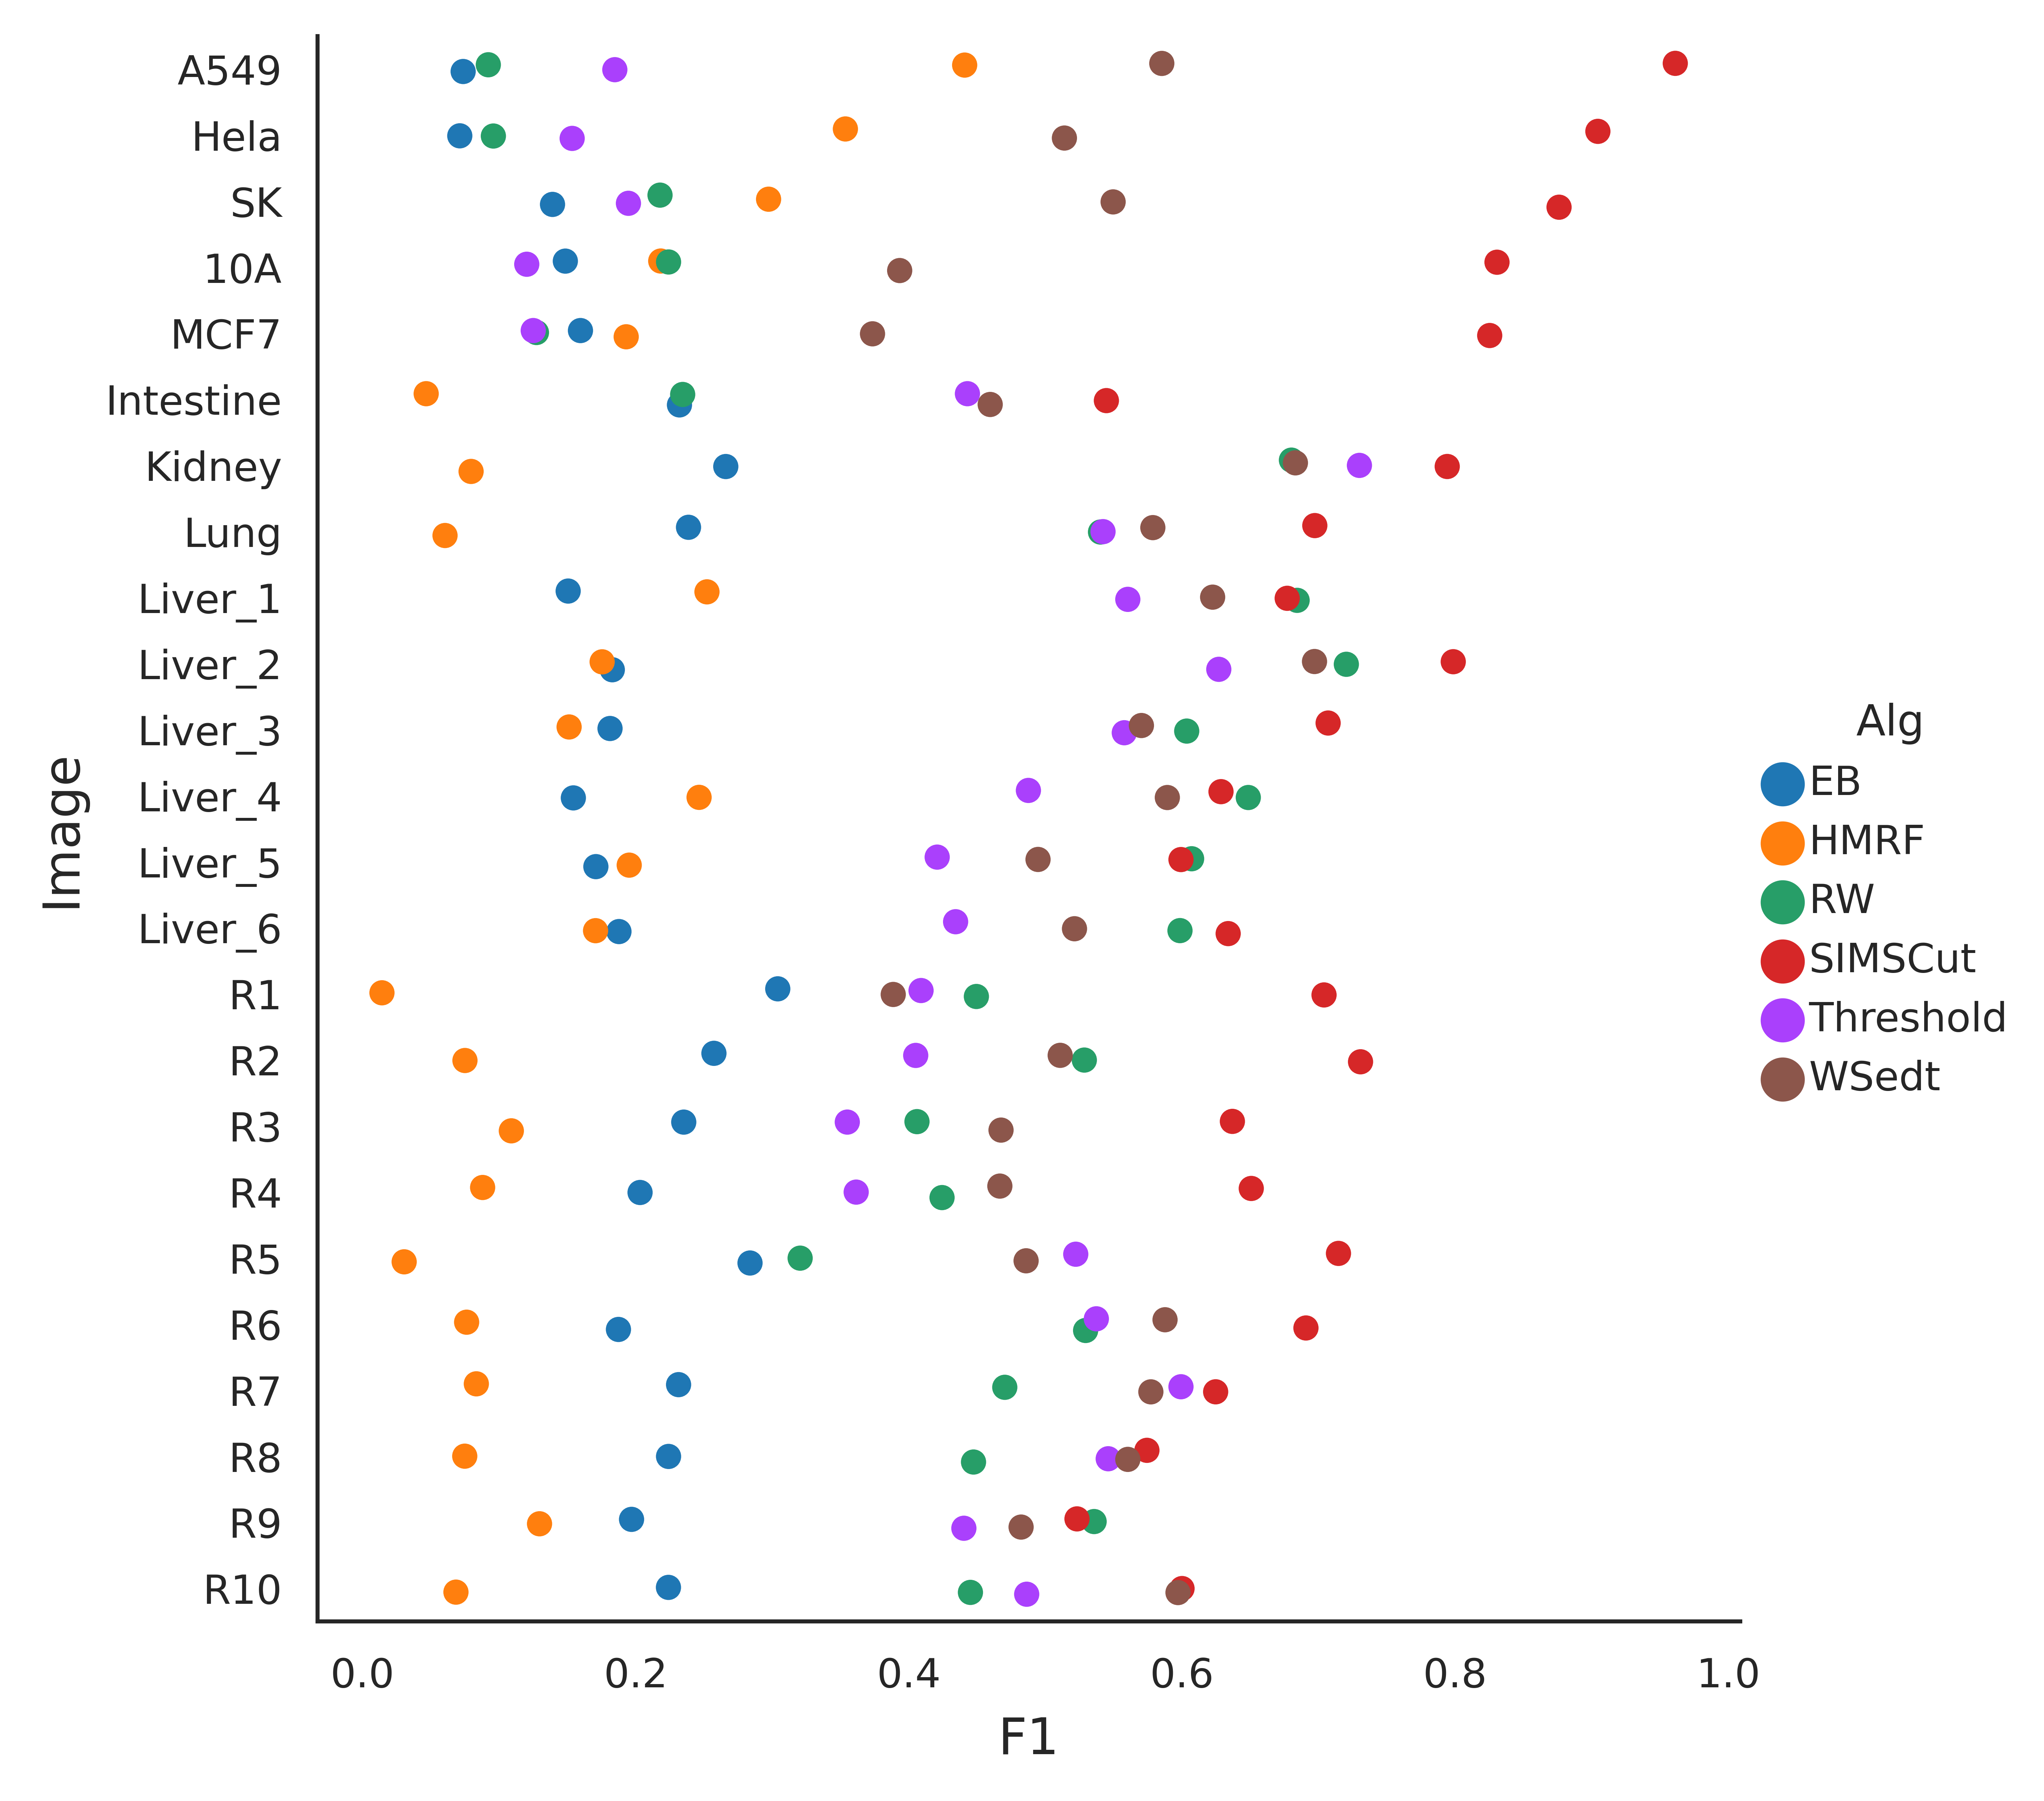

In [10]:
results = pd.DataFrame({'Image':[],'Type':[],'Alg':[],'Parameter':[],'Threshold':[],'AP':[],'F1':[],'Jaccard':[],'TP':[],'FP':[],'FN':[],'Count':[]})

for i in range(len(tissue_list)):
    test_tissue = tissue_list[i]
    cur_human = Human_int_dict[test_tissue]
    cur_type = type_list[i]
    for alg in Alg_dict.keys():
#     for alg in ['SIMSCut']:

        cur_rst_dict = Alg_dict[alg]
        
        cur_tissue_dict = cur_rst_dict[test_tissue]
#             cur_tissue_dict is either a numpy matrix or a dict
        if isinstance(cur_tissue_dict,np.ndarray):
            cur_int = cur_tissue_dict
            if cur_type=='CellLine':
                cur_int = filter_mask(cur_int,threshold=(0,60))
            else:
                cur_int = filter_mask(cur_int,threshold=(0,20))
                
            k=-1
            
            print('{0} {1} {2}'.format(test_tissue,alg,k))
            count = np.unique(cur_int).shape[0]-1
            results = compute_af1_results(cur_human, cur_int, results, test_tissue,alg,k,count,cur_type)
#             results = compute_af1_results( cur_int,cur_human, results, test_tissue,alg,k,count)

        elif isinstance(cur_tissue_dict,dict):
            for k in cur_tissue_dict.keys():
                cur_int = cur_tissue_dict[k]
#                 cur_int = filter_mask(cur_int,threshold=(0,20))
                if cur_type=='CellLine':
                    cur_int = filter_mask(cur_int,threshold=(0,60))
                else:
                    cur_int = filter_mask(cur_int,threshold=(0,20))
              
                print('{0} {1} {2}'.format(test_tissue,alg,k))
                count = np.unique(cur_int).shape[0]-1
                
                results = compute_af1_results(cur_human, cur_int, results, test_tissue,alg,k,count,cur_type)
#                 results = compute_af1_results( cur_int,cur_human, results, test_tissue,alg,k,count)
                
                    
rst_agg = results[results.Threshold>=0.1].groupby(['Image','Alg'], as_index=False).agg({"F1": 'max'})

# filter(0,20) UOI>=0.05
g = sns.catplot(y="Image", x="F1", hue="Alg",order=tissue_list,orient='h',
                 data=rst_agg[rst_agg.Alg!='WSgrad'])
        
        
        
        


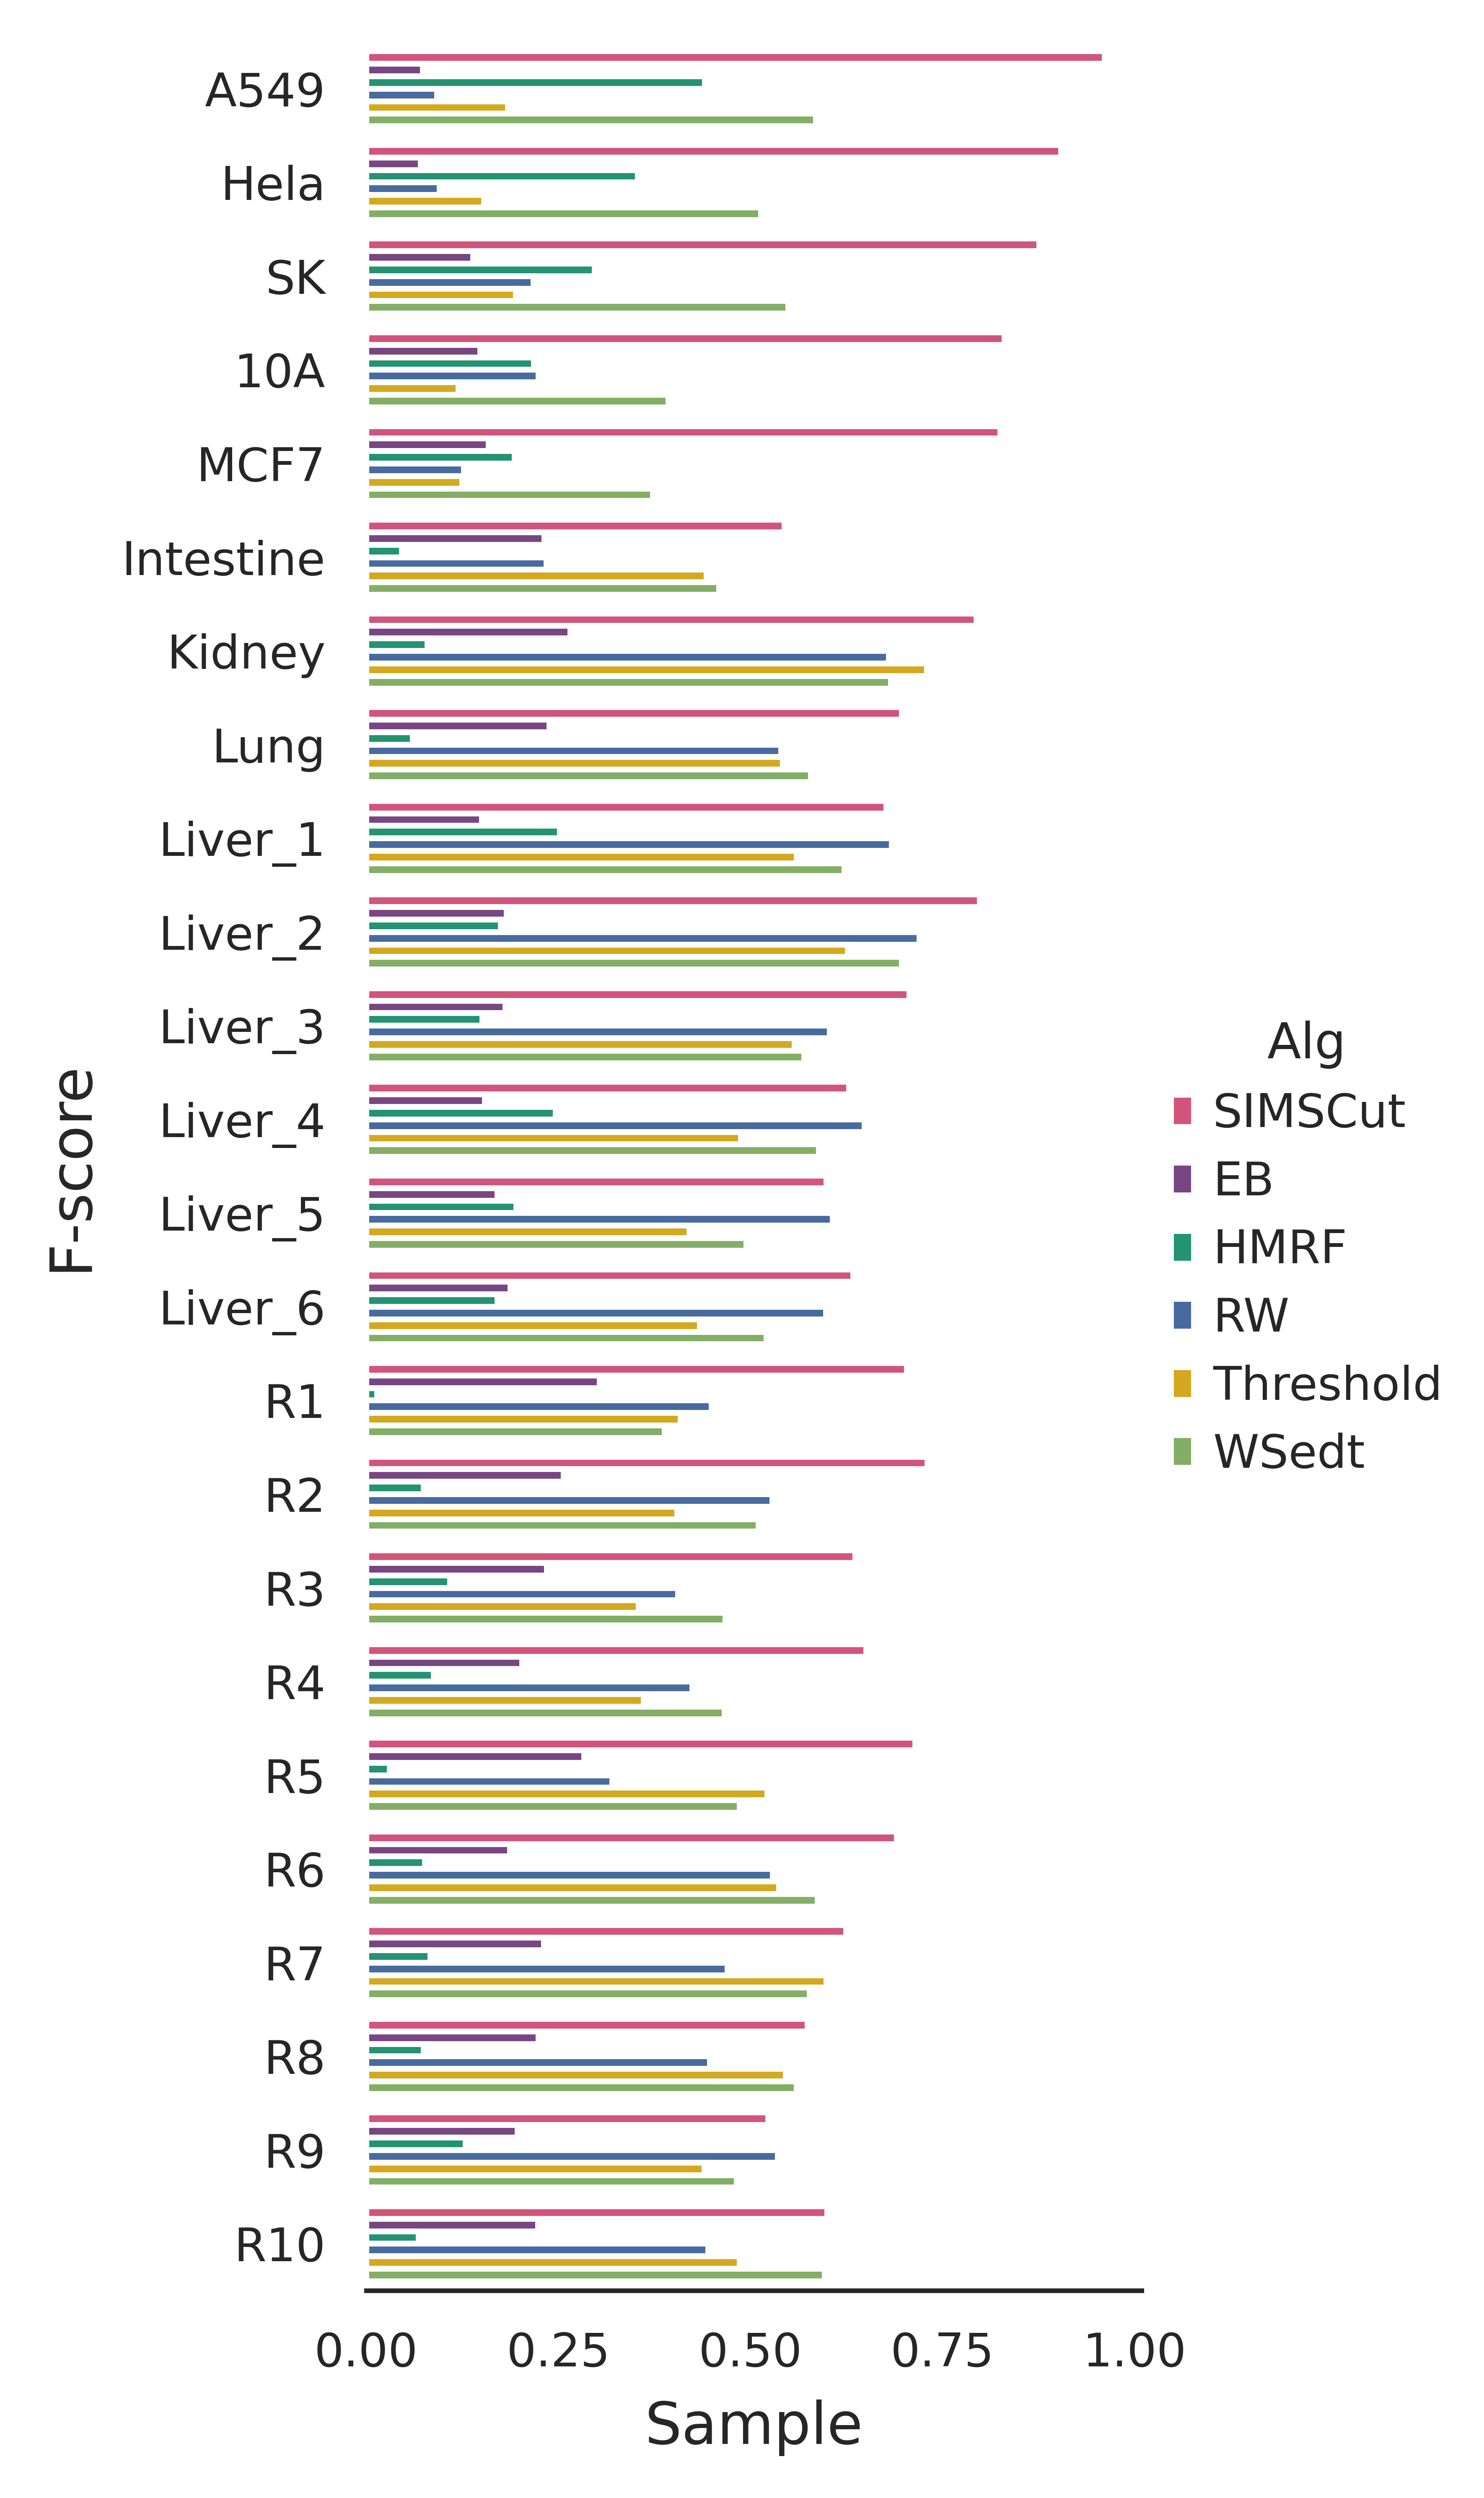

In [46]:
cmp_bold = palettable.cartocolors.qualitative.Bold_10.mpl_colors
cmp_use = [cmp_bold[4],cmp_bold[0],cmp_bold[1],cmp_bold[2],cmp_bold[3],cmp_bold[5]]
hue_order = ['SIMSCut','EB','HMRF','RW','Threshold','WSedt']
g = sns.catplot(
    data=rst_agg[rst_agg.Alg!='WSgrad'], kind="bar",
    x="F1", y="Image", hue="Alg",aspect=0.5,
    ci="sd", alpha=1, height=6,order=tissue_list,palette=cmp_use,
    orient='h',hue_order=hue_order
)
g.despine(left=True)
g.set_axis_labels("Sample", "F-score")
# g.legend.set_title("")

In [ ]:
cmp_use = palettable.cartocolors.qualitative.Bold_10.mpl_colors
hue_order = ['SIMSCut','EB','HMRF','RW','Threshold','WSedt']
g = sns.catplot(
    data=rst_agg[rst_agg.Alg!='WSgrad'], kind="bar",
    x="F1", y="Image", hue="Alg",aspect=0.5,
    ci="sd", alpha=1, height=6,order=tissue_list,palette=cmp_use,
    orient='h',hue_order=hue_order
)
g.despine(left=True)
g.set_axis_labels("Sample", "F-score")
# g.legend.set_title("")